In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(43)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255, x_test/255 #делаем из 0-255 --> 0-1

11490434/11490434 [==============================] - 2s 0us/step


9


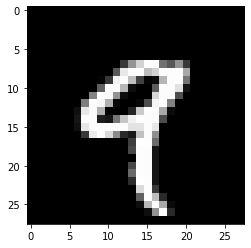

In [4]:
plt.imshow(x_train[4], cmap='gray')
print(y_train[4])

In [5]:
#что нам дадут стандартные методы понижения размерности?
from sklearn.decomposition import PCA

In [7]:
x_test.shape
#вывод надо сделать reshape

(10000, 28, 28)

In [10]:
pca = PCA()
pics_pca = pca.fit_transform(x_test.reshape((x_test.shape[0], -1)))

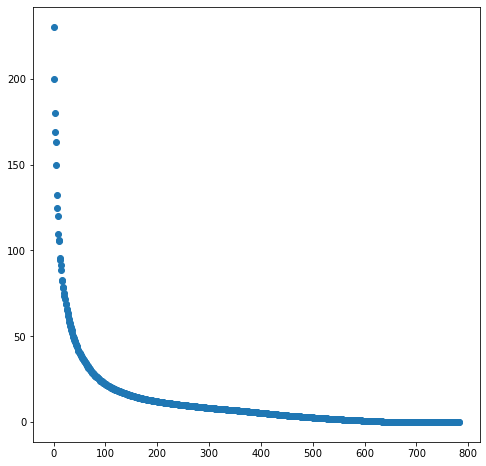

In [12]:
fig = plt.figure(figsize=(8,8))
plt.plot(pca.singular_values_, 'o')
#это график про что-то метод главных компонент, видно что надо хотя бы 100 чего-то это дофига

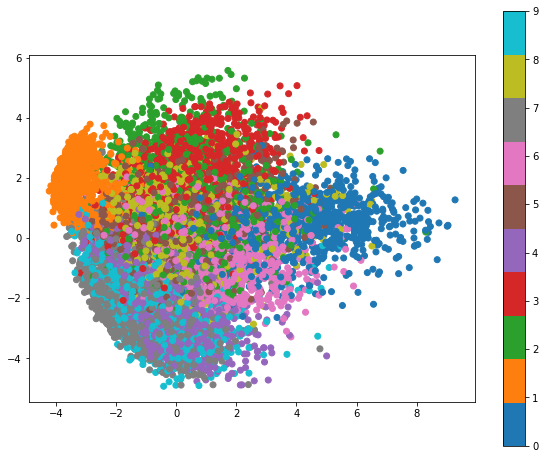

In [15]:
fig = plt.figure(figsize=(10,8))
plt.gca().set_aspect('equal') #чтобы оси равные были
plt.scatter(*pics_pca[:,:2].T, c=y_test, cmap='tab10')
plt.colorbar()
#видно что какая-то анархия, методом главных компонент тут не получится

In [17]:
#ок, пробуем некст метод
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2)
pics_tsne = tsne.fit_transform(x_test.reshape((x_test.shape[0], -1)))

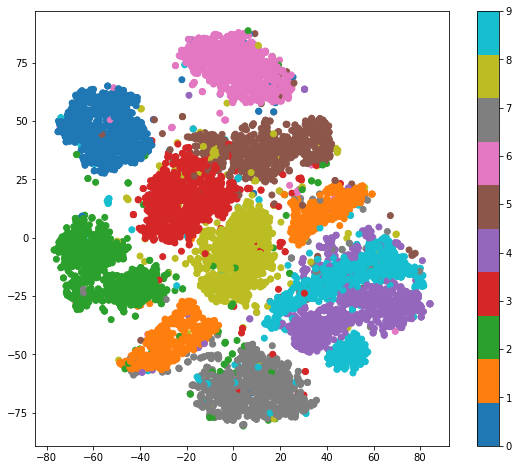

In [20]:
fig = plt.figure(figsize=(10,8))
plt.gca().set_aspect('equal') #чтобы оси равные были
plt.scatter(*pics_tsne[:,:2].T, c=y_test, cmap='tab10')
plt.colorbar()
#тут уже кластеры четко видны, неплохо

In [24]:
#перейдем к нейросетям: напишем нейросеть
INPUT_SHAPE = (28, 28)
HIDDEN_CH1 = 24
HIDDEN_CH2 = 36
LATENT_DIM = 8

def get_model(): #описываем то что на вход подается
    inputs = tf.keras.Input(shape=INPUT_SHAPE, name='encoder_input')
    
    #первая часть: кодирование
    encoder = tf.keras.Sequential([
                inputs,
                tf.keras.layers.Reshape((*INPUT_SHAPE, 1)),
                tf.keras.layers.Conv2D(HIDDEN_CH1, (3,3), strides=(2,2), activation='relu'),
                tf.keras.layers.Conv2D(HIDDEN_CH2, (3,3), strides=(2,2), activation='relu', use_bias=False),
                tf.keras.layers.Conv2D(LATENT_DIM, (6,6), activation='sigmoid', use_bias=False, name='encoder_out'),
                tf.keras.layers.Flatten(),]
                )
    
    #reshape это делаем чб, conv2d - сверточный слой, strides про то что мы ходим не на один а на каждый второй
    #потом во втором слове use_bias это про чето не добавили чето; в третьем слое шаг 1 поэтому убрали strides
    #последний слой просто делает нам вектор какой надо - просто длины 8 (типа не (8,1), просто 8)
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Reshape((1,1,LATENT_DIM)),
        tf.keras.layers.Conv2DTranspose(HIDDEN_CH2, (6,6), activation='relu', use_bias=False),
        tf.keras.layers.Conv2DTranspose(HIDDEN_CH2, (3,3), strides=(2,2), activation='relu', use_bias=False),
        tf.keras.layers.Conv2DTranspose(HIDDEN_CH1, (4,4), strides=(2,2), activation='relu', use_bias=False),
        tf.keras.layers.Conv2DTranspose(1, (1,1), activation='sigmoid', use_bias=False),
        tf.keras.layers.Reshape(INPUT_SHAPE),
    ])
    
    #encoder уменьшает размерность (в конце =1, просто число) и повышает каналы, decoder соответственно наоборот
    #нормализейшн среднее делает примерно = 0, дисперсию = 1
    #то что обратно два HIDDEN_CH2 это видимо просто так лучше работает, можно было и LATENT_DIM
    #то что (4,4) а не (3,3) это тоже так надо, ибо хотим исходную размерность а видимо где-то потеряли одну размерность
    
    autoencoder = tf.keras.Model(inputs=inputs, outputs=decoder(encoder(inputs)))
    
    return autoencoder, encoder, decoder

model, encoder, decoder = get_model()

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 sequential_2 (Sequential)   (None, 8)                 18384     
                                                                 
 sequential_3 (Sequential)   (None, 28, 28)            35896     
                                                                 
Total params: 54,280
Trainable params: 54,280
Non-trainable params: 0
_________________________________________________________________


In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(1000).batch(4)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test)).shuffle(1000).batch(4)

In [28]:
learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='MSE')
fit = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
15000/15000 [==============================] - 68s 5ms/step - loss: 0.0270 - val_loss: 0.0236
Epoch 2/5
15000/15000 [==============================] - 72s 5ms/step - loss: 0.0226 - val_loss: 0.0223
Epoch 3/5
15000/15000 [==============================] - 74s 5ms/step - loss: 0.0216 - val_loss: 0.0218
Epoch 4/5
15000/15000 [==============================] - 76s 5ms/step - loss: 0.0211 - val_loss: 0.0212
Epoch 5/5
15000/15000 [==============================] - 75s 5ms/step - loss: 0.0208 - val_loss: 0.0211


In [29]:
#в ячейке выше про train/test dataset это просто перемешали (можно было и не делать)
#Adam это просто усовершенствованный градиентный спуск (который знает про предыдущий шаг)

In [31]:
tsne_enc = TSNE(n_components=2)
encoded = encoder.predict(x_test)
pics_tsne = tsne.fit_transform(encoded.reshape((encoded.shape[0], -1)))

313/313 [==============================] - 1s 2ms/step


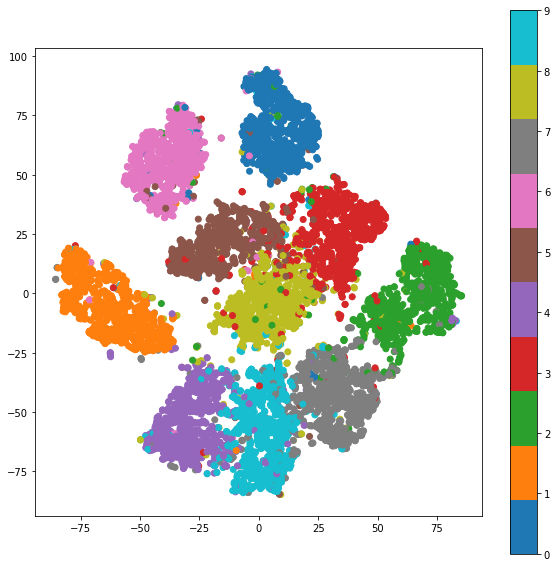

In [33]:
fig = plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
plt.scatter(*pics_tsne.T, c=y_test, cmap='tab10')
plt.colorbar()
#видно что с минимальными потерями уменьшили размерность данных, картинка особо не ухудшилась

In [37]:
decoded = model.predict(x_test)

313/313 [==============================] - 2s 6ms/step


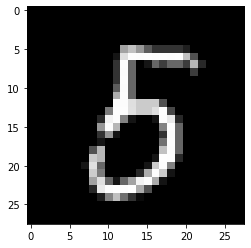

In [38]:
N = 45
plt.imshow(x_test[N].reshape((28,28)), cmap='gray')

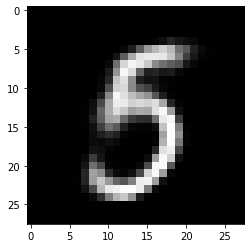

In [40]:
plt.imshow(decoded[N].reshape((28,28)), cmap='gray')